<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/17_HTR_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
word_length = 10
image_height = 200
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, rand_x=5, rand_y=3, pad_length=word_length)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, rand_x=5, rand_y=3, pad_length=word_length)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
from Layers import *

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt
import math
import random

to        


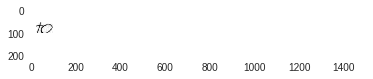

is        


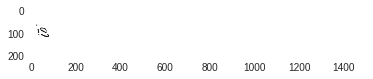

to        


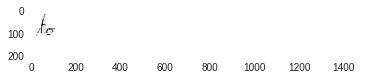

to        


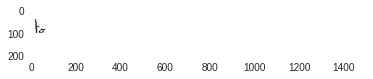

in        


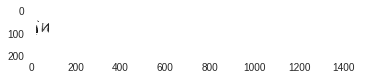

by        


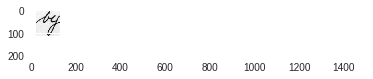

it        


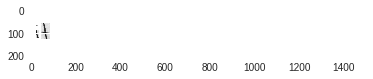

of        


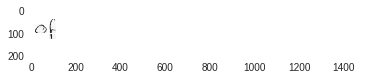

he        


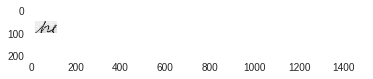

in        


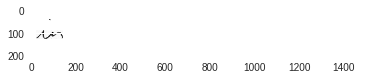

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch




target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

for i in range(0, 10):
  print(train_set.decode_word(target[i,:]))
  y = data.squeeze(1)
  plt.imshow(y[i].cpu(), cmap="gray")
  plt.show()


In [0]:
data.shape

torch.Size([100, 1, 200, 1500])

In [0]:
patch_height = 200
patch_width = 20
patches_count = 3#math.floor(1500/20)

In [0]:
class HTRPatchEncoder(nn.Module):
  def __init__(self, batchnorm=False, dropout=False):
    super(HTRPatchEncoder, self).__init__()

    self.convolutions = nn.Sequential(
        
    ConvLayer([1, 8, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
    ConvLayer([8, 16, 3], padding=0, stride=(2,1), bn=batchnorm, pool_layer=None),
    ConvLayer([16, 32, 3], padding=0, stride=(2,1), bn=batchnorm, pool_layer=None),
    ConvLayer([32, 64, 3], padding=0, stride=(2,1), bn=batchnorm, pool_layer=None))
    #ConvLayer([32, 64, 1], padding=0, stride=(1,49), bn=batchnorm, pool_layer=None))

    #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
  def forward(self, x):
    h = self.convolutions(x)
    #print(h.shape)
    #h = h.squeeze(-1)
    #h = h.flatten(start_dim=1)
    #h = self.fc(h)
    #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
    #h = h.permute([0, 2, 1])
    h = h.flatten(start_dim=1)
    return h
  
patch_encoder = HTRPatchEncoder().to(device)  

In [0]:
patch_idx = 5
patch = data[:, :, :, patch_width*patch_idx: patch_width*(patch_idx + 1)]

In [0]:
patch.shape

torch.Size([100, 1, 200, 20])

In [0]:
c = patch_encoder(patch)

In [0]:
c.shape

torch.Size([100, 2112])

In [0]:
class HTRGenerator(nn.Module):
  def __init__(self, ntoken, word_length, loss_fn, encoded_width=4, encoded_height=64, batchnorm=False, dropout=True):
    super(HTRGenerator, self).__init__()
    self.ntoken = ntoken
    #self.encoded_width = encoded_width
    #self.encoded_height = encoded_height
    self.lstm_size = 512
    self.lstm_layers = 2
    self.emb_size = 128
    self.word_size = word_length
    self.random_size = 20
    self.loss_fn = loss_fn
    self.encoded_size = 2112
    features_size = self.encoded_size + self.emb_size*word_length

    lstm_inp_size = features_size

    self.embedding = nn.Embedding(ntoken, self.emb_size)
    self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
    
    rnn_out = 1*self.lstm_size*1
    out_size = patch_width*patch_height
    
    from math import floor
    
    self.decoder = FullyConnectedX([rnn_out, floor(out_size*0.3), floor(out_size*0.5), floor(out_size*0.7), out_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())
    
    attention_inp = self.lstm_size*self.lstm_layers + self.word_size*self.emb_size
    self.attention = FullyConnectedX([attention_inp, floor(attention_inp*1.2), floor(attention_inp*0.7), floor(attention_inp*0.4),  self.word_size], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
    
    #self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
    #self.drop = nn.Dropout(0.3)

    #self.fc = FullyConnectedX([features_size, floor(features_size*0.7), floor(features_size*0.5), lstm_inp_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())

  def generate_patch(self, word, prev_patch, hidden):
    #rnd = torch.randn((batch_size, self.random_size))
    emb = self.embedding(word)
    hidden_m = hidden.permute(1, 0, 2)
    hidden_m = hidden_m.flatten(start_dim=1)
    attention_inp = torch.cat([emb.flatten(start_dim=1), hidden_m], dim=1).detach()
    self.attention_weights = self.attention(attention_inp)
    self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(2)
    self.attention_weights = self.attention_weights.repeat([1, 1, self.emb_size])
    emb = emb * self.attention_weights
    rnn_inp = torch.cat([emb.flatten(start_dim=1), prev_patch.flatten(start_dim=1)], dim=1).detach()
    rnn_inp = rnn_inp.unsqueeze(0)
    #print("fewafwef")
    #print(rnn_inp.shape)
    deconv_inp, new_hidden = self.rnn(rnn_inp, hidden)
    
    deconv_inp = deconv_inp.squeeze(0)
    #print("deconv")
    #print(deconv_inp.shape)
    dec = self.decoder(deconv_inp)
    
    #fawefjawifuief
    
    #dec = dec.reshape(batch_size, patch_height, patch_width)
    
    dec = dec.view(-1, patch_height, patch_width)
    return dec, new_hidden
    
  
  def makePatch(self):
    return torch.zeros(batch_size, self.encoded_size).to(device)
    
    
  def makeHidden(self):
    h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
    return h1
    
    
max_word_size = 10
#criterion = F.binary_cross_entropy_with_logits
criterion = F.mse_loss
generator = HTRGenerator(len(train_set.codes), max_word_size, criterion).to(device)


        
        
        

In [0]:
hidden = generator.makeHidden()
current_patch = generator.makePatch()
#generator.generate_patch(target, current_patch, hidden)

In [0]:
encoder_optimizer = optim.Adam(patch_encoder.parameters(), lr=1e-4, weight_decay=0.00005)
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00005)
                               
def process_batch(batch_idx, data, target, force=False):
  encoder_optimizer.zero_grad()
  generator_optimizer.zero_grad()
  hidden = generator.makeHidden()
  oldPatch = generator.makePatch()
  loss = 0
  #plt.imshow(data[0, 0, :, :].cpu().detach().numpy())
  #plt.show()
  
  
  for patch_idx in range(0, patches_count):
    patch = data[:, :, :, patch_width*patch_idx: patch_width*(patch_idx + 1)]
    #print(patch.shape)
    #plt.imshow(patch[0, 0, :, :].cpu().detach().numpy(), cmap="gray")
    #plt.show()
    
    enc = patch_encoder(patch)
    gen, hidden = generator.generate_patch(target, enc, hidden)    
    gen = gen.unsqueeze(1)
#     if force:
#       oldPatch = patch_encoder(patch).detach()
#     else:
#       oldPatch = patch_encoder(gen).detach()
    
    
    #if patch_idx > 0:
    #  print("%d O %f %f" %(patch_idx, gen.min(), gen.max()))
    loss += generator.loss_fn(patch, gen)
  if batch_idx %50 == 0:
    print("Batch %d. Loss %f."%(batch_idx, loss.item()))  
  l = loss.item()
  loss.backward()
  encoder_optimizer.step()
  generator_optimizer.step()                               
  return l

In [0]:
def train(epoch):
  print("Epoch %d" % epoch)
  train_set.to_start(-1)
  batch_idx = 0
  train_loss = 0
  while True:
    batch = train_set.make_batch(use_binarization=True)
    if batch is None:
      break
    data, target = batch
    data = data/255.0
    data = data.unsqueeze(1).to(device)
    data = data.to(device)
    target = target.to(device)
    train_loss += process_batch(batch_idx, data, target)
    batch_idx += 1
  print("Train loss: %f" % (train_loss/batch_idx))

In [0]:
def process_test_batch(batch_idx, data, target):
  encoder_optimizer.zero_grad()
  generator_optimizer.zero_grad()
  hidden = generator.makeHidden()
  oldPatch = generator.makePatch()
  loss = 0
  outputs = []
  for patch_idx in range(0, patches_count):
    patch = data[:, :, :, patch_width*patch_idx: patch_width*(patch_idx + 1)]
    enc = patch_encoder(patch)
    gen, hidden = generator.generate_patch(target, enc, hidden)  
    #if patch_idx > 0:
    #  print("%d O %f %f" %(patch_idx, gen.min(), gen.max()))

    outputs.append(gen)
    gen = gen.unsqueeze(1)
    oldPatch = patch_encoder(gen).detach()
    #print(patch.shape)
    #print(gen.shape)
    loss += generator.loss_fn(patch, gen)
  if batch_idx %10 == 0:
    output_img = torch.cat(outputs, dim=2)
    print("min %f max %f" %(output_img.min(), output_img.max()))
    plt.imshow(output_img[0].detach().cpu().numpy(), cmap="gray")
    plt.show()
    print("Batch %d. Loss %f."%(batch_idx, loss.item()))  
    
  return loss.item()

def test(epoch):
  print("Testing...")
  test_set.to_start(-1)
  batch_idx = 0
  test_loss = 0
  while True:
    batch = test_set.make_batch(use_binarization=True)
    if batch is None:
      break
    data, target = batch
    data = data/255.0
    data = data.unsqueeze(1).to(device)
    data = data.to(device)
    target = target.to(device)
    test_loss += process_test_batch(batch_idx, data, target)
    batch_idx += 1
  print("Test loss: %f" % (test_loss/batch_idx))
    

In [0]:
#test(0)

Epoch 0
Batch 0. Loss 2.863123.
Batch 50. Loss 0.122672.
Batch 100. Loss 0.117641.
Batch 150. Loss 0.115145.
Batch 200. Loss 0.126192.
Batch 250. Loss 0.125804.
Batch 300. Loss 0.121124.
Batch 350. Loss 0.127157.
Batch 400. Loss 0.121698.
Batch 450. Loss 0.113411.
Batch 500. Loss 0.120348.
Batch 550. Loss 0.115074.
Train loss: 0.185367
Testing...
min 0.999920 max 1.000000


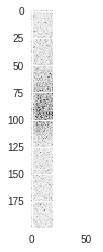

Batch 0. Loss 0.130173.
min 0.999943 max 1.000000


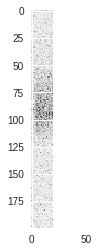

Batch 10. Loss 0.122876.
min 0.998957 max 1.000000


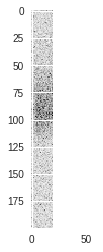

Batch 20. Loss 0.131640.
min 0.999877 max 1.000000


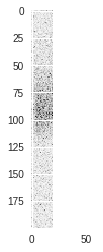

Batch 30. Loss 0.129722.
min 0.999946 max 1.000000


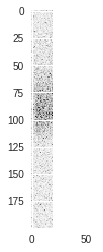

Batch 40. Loss 0.118602.
min 0.979987 max 1.000000


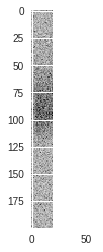

Batch 50. Loss 0.118224.
min 0.999896 max 1.000000


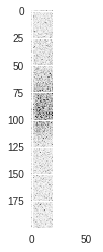

Batch 60. Loss 0.118338.
Test loss: 0.126169
Epoch 1
Batch 0. Loss 0.123304.
Batch 50. Loss 0.120983.
Batch 100. Loss 0.127369.
Batch 150. Loss 0.122516.
Batch 200. Loss 0.125291.
Batch 250. Loss 0.125516.
Batch 300. Loss 0.114794.
Batch 350. Loss 0.119205.
Batch 400. Loss 0.117623.
Batch 450. Loss 0.116379.
Batch 500. Loss 0.133783.
Batch 550. Loss 0.115068.
Train loss: 0.119907
Testing...
min 0.977249 max 1.000000


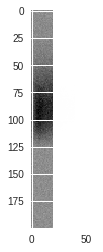

Batch 0. Loss 0.123904.
min 0.993144 max 1.000000


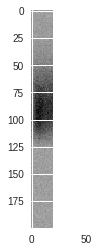

Batch 10. Loss 0.127202.
min 0.989935 max 1.000000


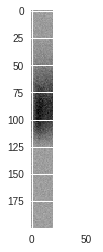

Batch 20. Loss 0.128585.
min 0.993295 max 1.000000


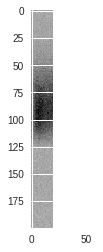

Batch 30. Loss 0.129335.
min 0.994570 max 1.000000


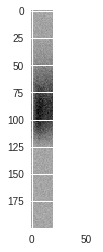

Batch 40. Loss 0.133614.
min 0.995280 max 1.000000


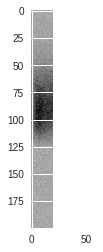

Batch 50. Loss 0.116831.
min 0.995774 max 1.000000


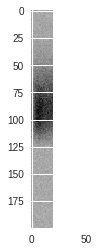

Batch 60. Loss 0.120328.
Test loss: 0.126100
Epoch 2
Batch 0. Loss 0.127415.
Batch 50. Loss 0.123953.
Batch 100. Loss 0.112226.
Batch 150. Loss 0.126483.
Batch 200. Loss 0.117355.
Batch 250. Loss 0.118938.
Batch 300. Loss 0.116885.
Batch 350. Loss 0.116158.
Batch 400. Loss 0.123745.
Batch 450. Loss 0.126049.
Batch 500. Loss 0.121193.
Batch 550. Loss 0.127533.
Train loss: 0.119868
Testing...
min 0.996166 max 1.000000


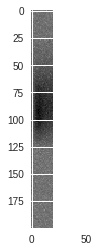

Batch 0. Loss 0.125699.
min 0.977150 max 1.000000


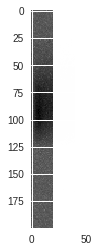

Batch 10. Loss 0.125263.
min 0.993007 max 1.000000


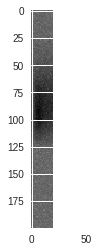

Batch 20. Loss 0.120236.
min 0.992505 max 1.000000


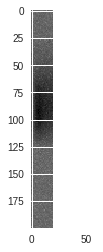

Batch 30. Loss 0.125279.
min 0.960235 max 0.999999


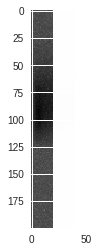

Batch 40. Loss 0.123281.
min 0.996478 max 1.000000


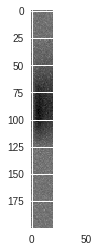

Batch 50. Loss 0.121688.
min 0.995678 max 1.000000


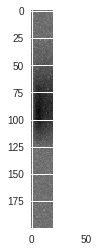

Batch 60. Loss 0.125883.
Test loss: 0.126207
Epoch 3
Batch 0. Loss 0.123845.
Batch 50. Loss 0.121208.
Batch 100. Loss 0.118414.
Batch 150. Loss 0.107048.
Batch 200. Loss 0.128620.
Batch 250. Loss 0.134057.
Batch 300. Loss 0.119683.
Batch 350. Loss 0.127923.
Batch 400. Loss 0.125796.
Batch 450. Loss 0.118253.
Batch 500. Loss 0.116820.
Batch 550. Loss 0.116172.
Train loss: 0.119838
Testing...
min 0.990909 max 1.000000


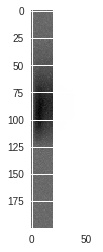

Batch 0. Loss 0.133522.
min 0.989194 max 1.000000


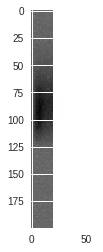

Batch 10. Loss 0.115967.
min 0.949938 max 0.999991


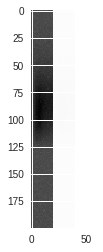

Batch 20. Loss 0.125786.
min 0.989718 max 1.000000


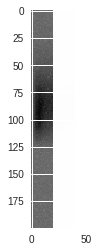

Batch 30. Loss 0.125654.
min 0.990847 max 1.000000


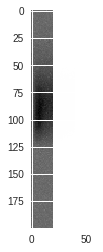

Batch 40. Loss 0.117998.
min 0.990839 max 1.000000


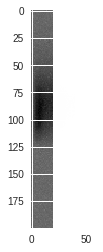

Batch 50. Loss 0.114347.
min 0.991882 max 1.000000


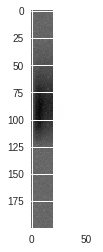

Batch 60. Loss 0.122785.
Test loss: 0.126325
Epoch 4
Batch 0. Loss 0.122158.
Batch 50. Loss 0.127252.
Batch 100. Loss 0.115299.
Batch 150. Loss 0.118326.
Batch 200. Loss 0.116059.
Batch 250. Loss 0.115608.
Batch 300. Loss 0.128522.
Batch 350. Loss 0.130986.
Batch 400. Loss 0.128607.
Batch 450. Loss 0.121101.
Batch 500. Loss 0.121171.
Batch 550. Loss 0.112929.
Train loss: 0.119885
Testing...
min 0.991069 max 1.000000


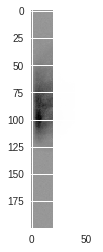

Batch 0. Loss 0.126728.
min 0.989371 max 1.000000


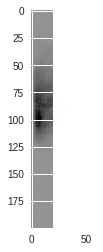

Batch 10. Loss 0.116369.
min 0.991922 max 1.000000


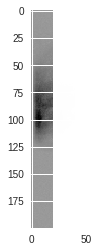

Batch 20. Loss 0.134873.
min 0.988037 max 1.000000


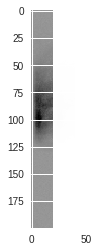

Batch 30. Loss 0.122651.
min 0.990027 max 1.000000


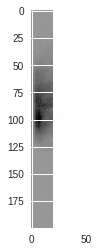

Batch 40. Loss 0.133926.
min 0.978599 max 0.999999


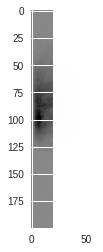

Batch 50. Loss 0.124366.
min 0.990973 max 1.000000


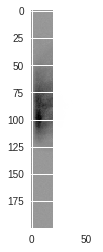

Batch 60. Loss 0.123500.
Test loss: 0.126381
Epoch 5
Batch 0. Loss 0.123030.
Batch 50. Loss 0.123119.
Batch 100. Loss 0.116818.
Batch 150. Loss 0.121977.
Batch 200. Loss 0.123646.
Batch 250. Loss 0.123427.
Batch 300. Loss 0.116480.
Batch 350. Loss 0.112549.
Batch 400. Loss 0.117315.
Batch 450. Loss 0.095865.
Batch 500. Loss 0.097159.
Batch 550. Loss 0.095773.
Train loss: 0.113286
Testing...
min 0.552485 max 0.999999


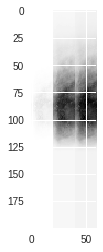

Batch 0. Loss 0.098632.
min 0.563789 max 0.999997


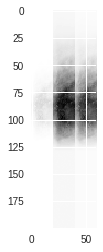

Batch 10. Loss 0.104635.
min 0.546206 max 0.999998


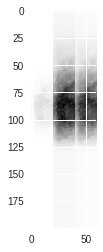

Batch 20. Loss 0.101521.
min 0.573125 max 0.999992


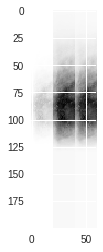

Batch 30. Loss 0.105176.
min 0.529717 max 0.999999


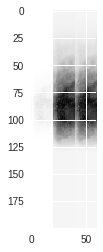

Batch 40. Loss 0.103708.
min 0.531907 max 0.999999


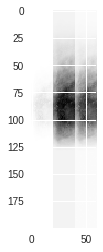

Batch 50. Loss 0.098519.
min 0.533486 max 0.999999


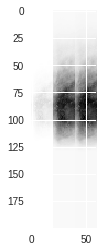

Batch 60. Loss 0.099330.
Test loss: 0.100652
Epoch 6
Batch 0. Loss 0.104151.
Batch 50. Loss 0.101280.
Batch 100. Loss 0.098771.
Batch 150. Loss 0.097206.
Batch 200. Loss 0.091335.
Batch 250. Loss 0.092923.
Batch 300. Loss 0.091437.
Batch 350. Loss 0.099593.
Batch 400. Loss 0.099517.
Batch 450. Loss 0.098523.
Batch 500. Loss 0.095235.
Batch 550. Loss 0.087288.
Train loss: 0.096685
Testing...
min 0.457368 max 1.000000


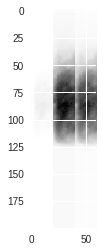

Batch 0. Loss 0.095257.
min 0.317835 max 1.000000


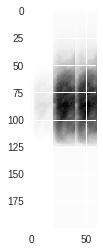

Batch 10. Loss 0.096862.
min 0.382150 max 1.000000


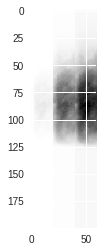

Batch 20. Loss 0.099504.
min 0.383528 max 1.000000


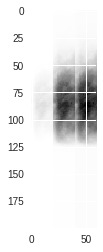

Batch 30. Loss 0.097247.
min 0.420174 max 1.000000


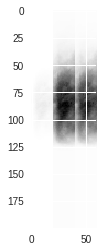

Batch 40. Loss 0.101322.
min 0.498597 max 1.000000


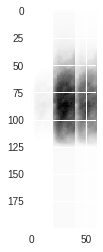

Batch 50. Loss 0.098376.
min 0.420432 max 0.999999


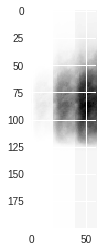

Batch 60. Loss 0.104157.
Test loss: 0.098886
Epoch 7
Batch 0. Loss 0.093564.
Batch 50. Loss 0.101008.
Batch 100. Loss 0.093725.
Batch 150. Loss 0.088045.
Batch 200. Loss 0.092258.
Batch 250. Loss 0.092350.
Batch 300. Loss 0.100541.
Batch 350. Loss 0.091309.
Batch 400. Loss 0.101467.
Batch 450. Loss 0.093532.
Batch 500. Loss 0.090702.
Batch 550. Loss 0.099936.
Train loss: 0.096082
Testing...
min 0.285209 max 0.999999


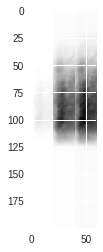

Batch 0. Loss 0.094281.
min 0.410907 max 0.999999


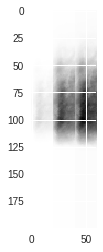

Batch 10. Loss 0.093441.
min 0.374060 max 0.999999


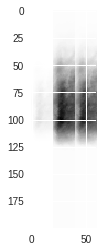

Batch 20. Loss 0.106847.
min 0.463058 max 1.000000


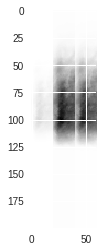

Batch 30. Loss 0.097904.
min 0.490344 max 0.999998


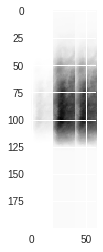

Batch 40. Loss 0.098549.
min 0.462833 max 1.000000


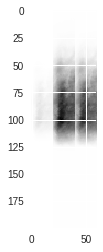

Batch 50. Loss 0.092452.
min 0.435607 max 0.999999


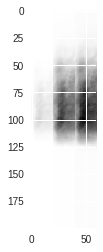

Batch 60. Loss 0.097234.
Test loss: 0.099030
Epoch 8
Batch 0. Loss 0.096115.
Batch 50. Loss 0.093352.
Batch 100. Loss 0.101433.
Batch 150. Loss 0.100525.
Batch 200. Loss 0.094794.
Batch 250. Loss 0.098495.
Batch 300. Loss 0.088786.
Batch 350. Loss 0.091338.
Batch 400. Loss 0.095814.
Batch 450. Loss 0.097374.
Batch 500. Loss 0.092759.
Batch 550. Loss 0.090548.
Train loss: 0.095570
Testing...
min 0.168575 max 1.000000


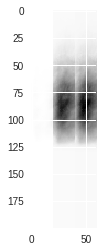

Batch 0. Loss 0.096486.
min 0.286891 max 1.000000


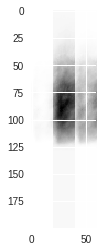

Batch 10. Loss 0.098441.
min 0.263271 max 1.000000


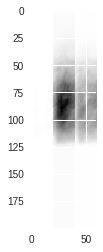

Batch 20. Loss 0.094569.
min 0.193503 max 1.000000


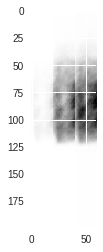

Batch 30. Loss 0.098789.
min 0.061737 max 1.000000


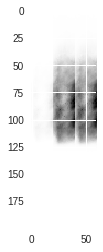

Batch 40. Loss 0.092699.
min 0.180007 max 1.000000


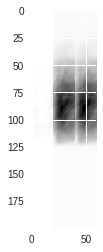

Batch 50. Loss 0.101078.
min 0.312236 max 1.000000


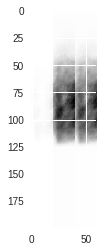

Batch 60. Loss 0.093952.
Test loss: 0.096812
Epoch 9
Batch 0. Loss 0.101265.
Batch 50. Loss 0.093993.
Batch 100. Loss 0.090018.
Batch 150. Loss 0.089244.
Batch 200. Loss 0.099605.
Batch 250. Loss 0.092919.
Batch 300. Loss 0.096593.
Batch 350. Loss 0.095729.
Batch 400. Loss 0.094800.
Batch 450. Loss 0.092229.
Batch 500. Loss 0.095340.
Batch 550. Loss 0.097050.
Train loss: 0.094164
Testing...
min 0.121756 max 0.999998


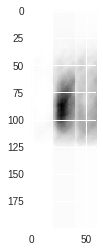

Batch 0. Loss 0.091568.
min 0.168071 max 0.999996


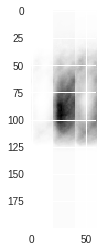

Batch 10. Loss 0.097538.
min 0.073461 max 0.999998


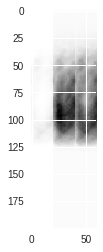

Batch 20. Loss 0.095513.
min 0.099133 max 0.999997


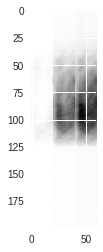

Batch 30. Loss 0.099556.
min 0.080788 max 0.999996


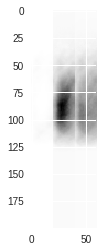

Batch 40. Loss 0.096739.
min -0.012456 max 0.999995


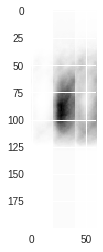

Batch 50. Loss 0.101602.
min 0.060086 max 0.999996


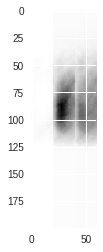

Batch 60. Loss 0.095755.
Test loss: 0.095642
Epoch 10
Batch 0. Loss 0.089691.
Batch 50. Loss 0.086288.
Batch 100. Loss 0.090610.
Batch 150. Loss 0.095149.
Batch 200. Loss 0.094859.
Batch 250. Loss 0.094336.
Batch 300. Loss 0.092856.
Batch 350. Loss 0.092070.
Batch 400. Loss 0.084776.
Batch 450. Loss 0.099176.
Batch 500. Loss 0.090138.
Batch 550. Loss 0.092272.
Train loss: 0.093135
Testing...
min 0.000790 max 0.999995


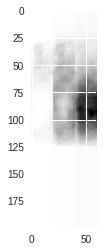

Batch 0. Loss 0.097013.
min 0.025398 max 0.999996


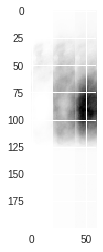

Batch 10. Loss 0.094544.
min -0.017390 max 0.999997


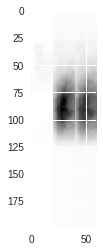

Batch 20. Loss 0.093296.
min 0.003895 max 0.999998


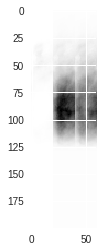

Batch 30. Loss 0.088746.
min -0.026165 max 0.999998


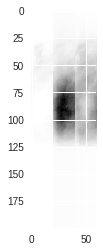

Batch 40. Loss 0.093838.
min -0.017322 max 0.999996


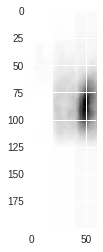

Batch 50. Loss 0.091427.
min -0.016031 max 0.999995


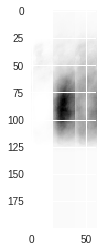

Batch 60. Loss 0.094413.
Test loss: 0.094766
Epoch 11
Batch 0. Loss 0.094325.
Batch 50. Loss 0.089175.
Batch 100. Loss 0.092778.
Batch 150. Loss 0.092295.
Batch 200. Loss 0.088894.
Batch 250. Loss 0.099615.
Batch 300. Loss 0.087751.
Batch 350. Loss 0.094355.
Batch 400. Loss 0.094381.
Batch 450. Loss 0.091397.
Batch 500. Loss 0.090187.
Batch 550. Loss 0.092797.
Train loss: 0.091775
Testing...
min -0.049911 max 0.999999


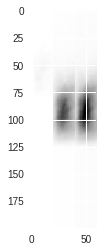

Batch 0. Loss 0.090334.
min 0.076711 max 1.000000


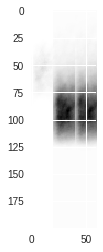

Batch 10. Loss 0.092334.
min 0.076297 max 0.999999


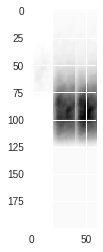

Batch 20. Loss 0.090679.
min -0.000143 max 1.000000


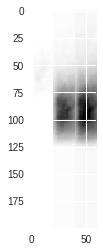

Batch 30. Loss 0.095169.
min 0.041013 max 0.999998


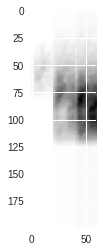

Batch 40. Loss 0.090620.
min 0.018872 max 1.000000


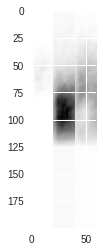

Batch 50. Loss 0.089328.
min -0.020637 max 1.000000


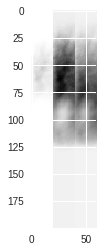

Batch 60. Loss 0.092437.
Test loss: 0.091766
Epoch 12
Batch 0. Loss 0.090466.
Batch 50. Loss 0.100453.
Batch 100. Loss 0.088666.
Batch 150. Loss 0.096303.
Batch 200. Loss 0.088710.
Batch 250. Loss 0.090875.
Batch 300. Loss 0.084494.
Batch 350. Loss 0.086601.
Batch 400. Loss 0.092911.
Batch 450. Loss 0.086297.
Batch 500. Loss 0.093061.
Batch 550. Loss 0.086566.
Train loss: 0.089023
Testing...
min -0.084860 max 1.000000


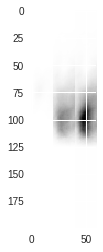

Batch 0. Loss 0.087139.
min -0.014374 max 1.000000


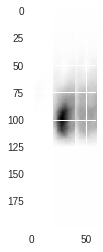

Batch 10. Loss 0.089068.
min -0.165629 max 1.000000


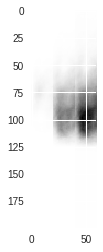

Batch 20. Loss 0.087665.
min -0.124948 max 1.000000


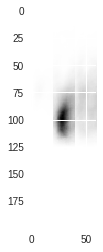

Batch 30. Loss 0.087838.
min -0.066751 max 1.000000


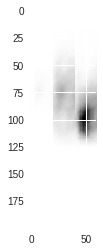

Batch 40. Loss 0.087794.
min -0.118323 max 1.000000


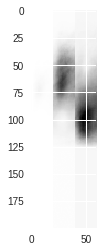

Batch 50. Loss 0.086880.
min -0.059202 max 1.000000


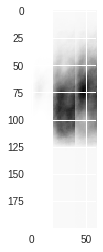

Batch 60. Loss 0.082704.
Test loss: 0.090102
Epoch 13
Batch 0. Loss 0.085233.
Batch 50. Loss 0.085390.
Batch 100. Loss 0.079598.
Batch 150. Loss 0.087955.
Batch 200. Loss 0.083548.
Batch 250. Loss 0.085004.
Batch 300. Loss 0.080871.
Batch 350. Loss 0.088986.
Batch 400. Loss 0.085355.
Batch 450. Loss 0.089743.
Batch 500. Loss 0.089547.
Batch 550. Loss 0.091135.
Train loss: 0.087151
Testing...
min 0.015941 max 1.000000


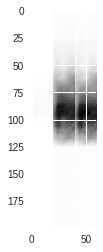

Batch 0. Loss 0.086545.
min 0.011008 max 1.000000


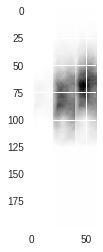

Batch 10. Loss 0.088613.
min -0.056835 max 1.000000


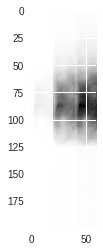

Batch 20. Loss 0.089316.
min -0.054377 max 1.000000


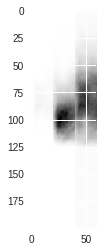

Batch 30. Loss 0.090746.
min -0.027376 max 1.000000


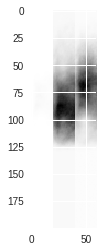

Batch 40. Loss 0.088416.
min -0.048517 max 1.000000


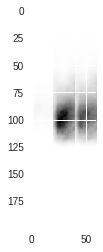

Batch 50. Loss 0.087834.
min -0.049396 max 1.000000


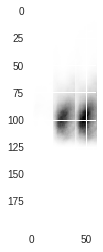

Batch 60. Loss 0.087143.
Test loss: 0.089525
Epoch 14
Batch 0. Loss 0.085085.
Batch 50. Loss 0.080804.
Batch 100. Loss 0.090546.
Batch 150. Loss 0.091996.
Batch 200. Loss 0.087874.
Batch 250. Loss 0.085544.
Batch 300. Loss 0.086218.
Batch 350. Loss 0.087822.
Batch 400. Loss 0.081828.
Batch 450. Loss 0.089045.
Batch 500. Loss 0.089472.
Batch 550. Loss 0.085680.
Train loss: 0.086494
Testing...
min 0.019752 max 1.000000


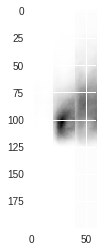

Batch 0. Loss 0.089006.
min -0.159350 max 1.000000


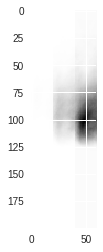

Batch 10. Loss 0.084687.
min -0.166167 max 1.000000


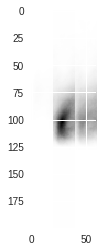

Batch 20. Loss 0.089430.
min -0.136578 max 1.000000


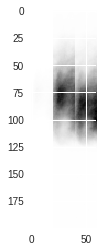

Batch 30. Loss 0.091862.
min 0.010688 max 1.000000


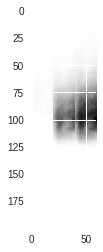

Batch 40. Loss 0.082795.
min -0.134116 max 1.000000


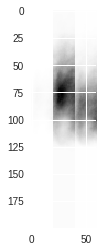

Batch 50. Loss 0.086934.
min -0.153564 max 1.000000


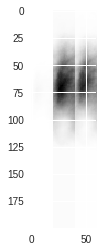

Batch 60. Loss 0.089526.
Test loss: 0.087544
Epoch 15
Batch 0. Loss 0.086759.
Batch 50. Loss 0.088802.
Batch 100. Loss 0.087301.
Batch 150. Loss 0.089612.
Batch 200. Loss 0.088478.
Batch 250. Loss 0.083896.
Batch 300. Loss 0.088410.
Batch 350. Loss 0.085593.
Batch 400. Loss 0.085203.
Batch 450. Loss 0.077548.
Batch 500. Loss 0.085265.
Batch 550. Loss 0.085172.
Train loss: 0.083888
Testing...
min 0.022464 max 0.999979


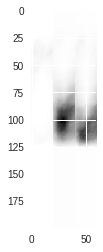

Batch 0. Loss 0.080548.
min -0.046002 max 0.999993


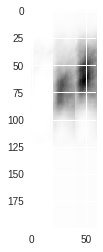

Batch 10. Loss 0.082162.
min 0.005725 max 0.999994


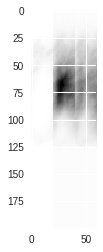

Batch 20. Loss 0.078223.
min 0.020725 max 0.999994


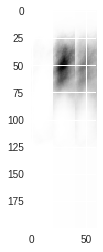

Batch 30. Loss 0.079804.
min -0.063927 max 0.999991


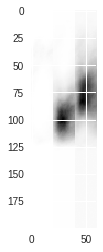

Batch 40. Loss 0.083020.
min -0.010562 max 0.999990


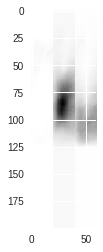

Batch 50. Loss 0.082997.
min -0.061447 max 0.999992


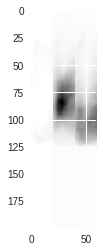

Batch 60. Loss 0.086631.
Test loss: 0.082985
Epoch 16
Batch 0. Loss 0.081572.
Batch 50. Loss 0.076964.
Batch 100. Loss 0.075152.
Batch 150. Loss 0.084957.
Batch 200. Loss 0.076200.
Batch 250. Loss 0.088842.
Batch 300. Loss 0.082162.
Batch 350. Loss 0.079045.
Batch 400. Loss 0.082804.
Batch 450. Loss 0.085491.
Batch 500. Loss 0.081494.
Batch 550. Loss 0.080044.
Train loss: 0.081730
Testing...
min -0.175025 max 0.999927


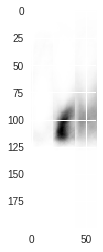

Batch 0. Loss 0.083537.
min -0.231538 max 0.999988


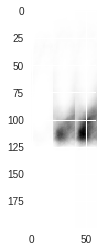

Batch 10. Loss 0.076099.
min -0.328570 max 0.999992


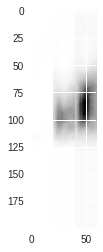

Batch 20. Loss 0.079301.
min -0.064276 max 0.999968


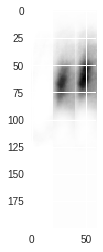

Batch 30. Loss 0.084842.
min -0.175297 max 0.999988


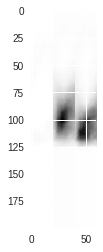

Batch 40. Loss 0.083375.
min -0.220498 max 0.999993


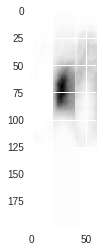

Batch 50. Loss 0.080725.
min -0.183622 max 0.999995


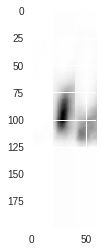

Batch 60. Loss 0.077554.
Test loss: 0.081709
Epoch 17
Batch 0. Loss 0.079646.
Batch 50. Loss 0.081613.
Batch 100. Loss 0.083061.
Batch 150. Loss 0.079478.
Batch 200. Loss 0.080891.
Batch 250. Loss 0.083098.
Batch 300. Loss 0.084022.
Batch 350. Loss 0.079817.
Batch 400. Loss 0.079827.
Batch 450. Loss 0.078216.
Batch 500. Loss 0.083378.
Batch 550. Loss 0.070961.
Train loss: 0.080710
Testing...
min -0.157568 max 0.999991


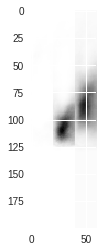

Batch 0. Loss 0.079264.
min -0.264866 max 0.999979


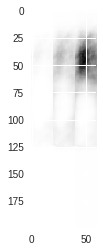

Batch 10. Loss 0.085696.
min -0.195335 max 0.999995


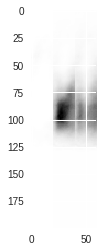

Batch 20. Loss 0.077923.
min -0.264822 max 0.999984


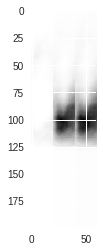

Batch 30. Loss 0.084824.
min -0.192934 max 0.999989


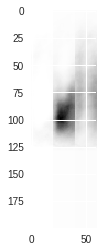

Batch 40. Loss 0.084575.
min -0.175451 max 0.999991


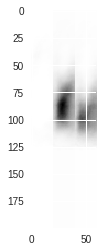

Batch 50. Loss 0.078370.
min -0.255038 max 0.999991


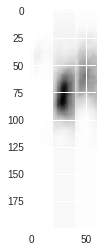

Batch 60. Loss 0.078036.
min -0.154862 max 0.999991


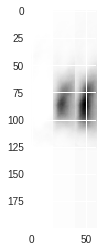

Batch 70. Loss 0.083868.
Test loss: 0.081527
Epoch 18
Batch 0. Loss 0.079923.
Batch 50. Loss 0.080045.
Batch 100. Loss 0.080898.
Batch 150. Loss 0.085900.
Batch 200. Loss 0.082053.
Batch 250. Loss 0.083733.
Batch 300. Loss 0.083643.
Batch 350. Loss 0.079667.
Batch 400. Loss 0.079349.
Batch 450. Loss 0.080962.
Batch 500. Loss 0.077498.
Batch 550. Loss 0.080609.
Train loss: 0.080859
Testing...
min -0.147656 max 0.999994


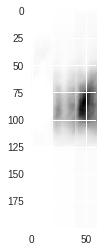

Batch 0. Loss 0.082914.
min -0.135801 max 0.999993


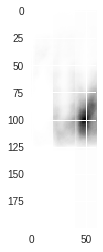

Batch 10. Loss 0.086945.
min -0.126605 max 0.999994


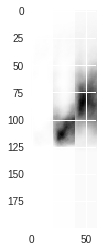

Batch 20. Loss 0.083808.
min -0.133328 max 0.999992


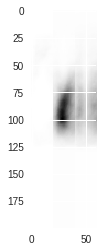

Batch 30. Loss 0.084351.
min -0.274230 max 0.999992


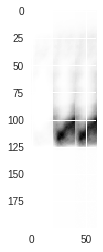

Batch 40. Loss 0.084385.
min -0.072723 max 0.999992


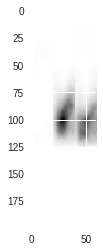

Batch 50. Loss 0.083849.
min -0.154606 max 0.999992


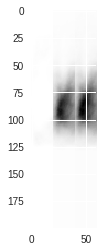

Batch 60. Loss 0.088808.
Test loss: 0.082247
Epoch 19
Batch 0. Loss 0.081842.
Batch 50. Loss 0.074450.
Batch 100. Loss 0.079899.
Batch 150. Loss 0.082565.
Batch 200. Loss 0.080933.
Batch 250. Loss 0.082021.
Batch 300. Loss 0.078390.
Batch 350. Loss 0.080821.
Batch 400. Loss 0.078723.
Batch 450. Loss 0.079414.
Batch 500. Loss 0.071762.
Batch 550. Loss 0.081492.
Train loss: 0.080427
Testing...
min -0.163443 max 0.999995


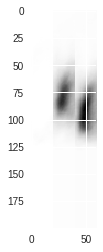

Batch 0. Loss 0.082910.
min -0.246088 max 0.999996


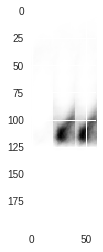

Batch 10. Loss 0.079612.
min -0.378431 max 0.999993


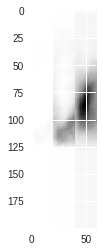

Batch 20. Loss 0.076773.
min -0.366751 max 0.999996


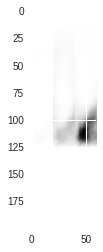

Batch 30. Loss 0.079956.
min -0.207115 max 0.999995


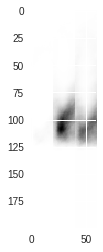

Batch 40. Loss 0.086024.
min -0.482748 max 0.999966


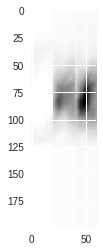

Batch 50. Loss 0.081034.
min -0.285090 max 0.999996


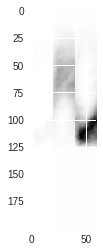

Batch 60. Loss 0.080888.
Test loss: 0.081545
Epoch 20
Batch 0. Loss 0.081399.
Batch 50. Loss 0.077268.
Batch 100. Loss 0.078550.
Batch 150. Loss 0.076589.
Batch 200. Loss 0.081901.
Batch 250. Loss 0.081169.
Batch 300. Loss 0.075390.
Batch 350. Loss 0.079174.
Batch 400. Loss 0.082084.
Batch 450. Loss 0.085128.
Batch 500. Loss 0.080536.
Batch 550. Loss 0.080837.
Train loss: 0.080010
Testing...
min -0.210545 max 0.999998


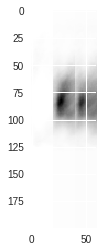

Batch 0. Loss 0.078139.
min -0.195592 max 0.999998


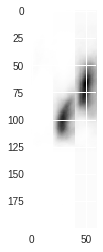

Batch 10. Loss 0.075071.
min -0.237355 max 0.999996


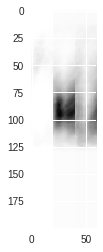

Batch 20. Loss 0.085965.
min -0.228640 max 0.999997


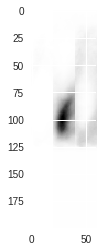

Batch 30. Loss 0.081188.
min -0.150354 max 0.999998


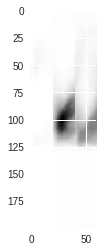

Batch 40. Loss 0.081572.
min -0.112256 max 0.999995


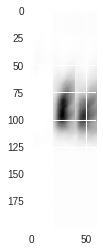

Batch 50. Loss 0.081239.
min -0.118521 max 0.999997


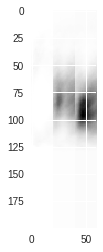

Batch 60. Loss 0.077856.
Test loss: 0.081191
Epoch 21
Batch 0. Loss 0.079519.
Batch 50. Loss 0.082292.
Batch 100. Loss 0.084006.
Batch 150. Loss 0.080651.
Batch 200. Loss 0.077807.
Batch 250. Loss 0.075224.
Batch 300. Loss 0.077908.
Batch 350. Loss 0.078500.
Batch 400. Loss 0.083904.
Batch 450. Loss 0.068118.
Batch 500. Loss 0.080246.
Batch 550. Loss 0.078052.
Train loss: 0.079999
Testing...
min -0.263014 max 0.999996


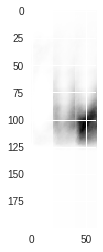

Batch 0. Loss 0.079045.
min -0.191058 max 0.999997


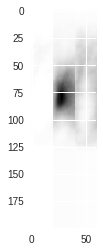

Batch 10. Loss 0.080954.
min -0.158036 max 0.999997


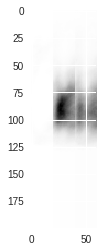

Batch 20. Loss 0.076274.
min -0.225505 max 0.999997


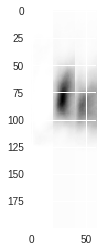

Batch 30. Loss 0.075918.
min -0.199989 max 0.999996


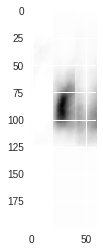

Batch 40. Loss 0.077457.
min -0.184440 max 0.999995


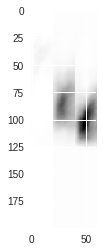

Batch 50. Loss 0.079900.
min -0.214708 max 0.999996


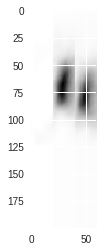

Batch 60. Loss 0.080862.
Test loss: 0.080209
Epoch 22
Batch 0. Loss 0.081189.
Batch 50. Loss 0.078515.
Batch 100. Loss 0.081633.
Batch 150. Loss 0.081158.
Batch 200. Loss 0.081373.
Batch 250. Loss 0.080701.
Batch 300. Loss 0.082562.
Batch 350. Loss 0.077201.
Batch 400. Loss 0.082070.
Batch 450. Loss 0.080811.
Batch 500. Loss 0.080306.
Batch 550. Loss 0.080703.
Train loss: 0.080119
Testing...
min -0.221093 max 0.999994


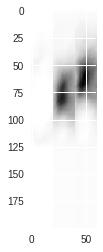

Batch 0. Loss 0.088057.
min -0.123143 max 0.999996


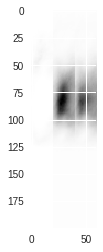

Batch 10. Loss 0.081683.
min -0.188636 max 0.999997


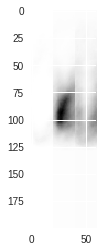

Batch 20. Loss 0.080795.
min -0.297708 max 0.999996


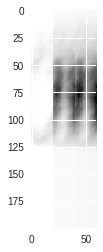

Batch 30. Loss 0.081059.
min -0.144823 max 0.999995


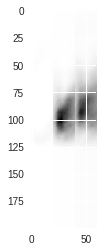

Batch 40. Loss 0.085828.
min -0.210194 max 0.999998


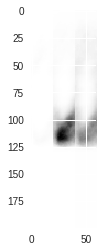

Batch 50. Loss 0.082663.
min -0.183587 max 0.999997


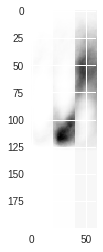

Batch 60. Loss 0.081428.
Test loss: 0.080291
Epoch 23
Batch 0. Loss 0.085660.
Batch 50. Loss 0.082108.
Batch 100. Loss 0.085722.
Batch 150. Loss 0.077321.
Batch 200. Loss 0.082289.
Batch 250. Loss 0.084115.
Batch 300. Loss 0.082194.
Batch 350. Loss 0.081249.
Batch 400. Loss 0.080024.
Batch 450. Loss 0.077191.
Batch 500. Loss 0.078075.
Batch 550. Loss 0.084605.
Train loss: 0.079789
Testing...
min -0.218348 max 0.999996


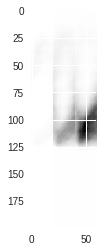

Batch 0. Loss 0.081849.
min -0.148092 max 0.999995


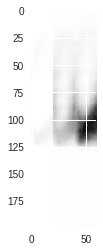

Batch 10. Loss 0.081783.
min -0.196579 max 0.999996


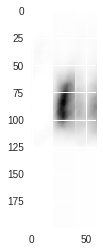

Batch 20. Loss 0.079604.
min -0.227912 max 0.999997


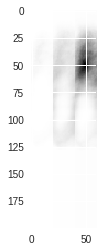

Batch 30. Loss 0.077501.
min -0.145663 max 0.999997


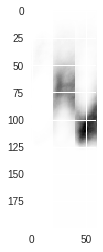

Batch 40. Loss 0.076891.
min -0.203702 max 0.999994


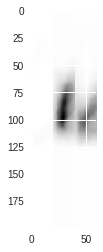

Batch 50. Loss 0.082410.
min -0.163823 max 0.999998


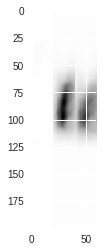

Batch 60. Loss 0.077790.
Test loss: 0.080430
Epoch 24
Batch 0. Loss 0.075266.
Batch 50. Loss 0.078959.
Batch 100. Loss 0.083825.
Batch 150. Loss 0.076606.
Batch 200. Loss 0.078672.
Batch 250. Loss 0.075745.
Batch 300. Loss 0.075641.
Batch 350. Loss 0.079100.
Batch 400. Loss 0.087802.
Batch 450. Loss 0.078543.
Batch 500. Loss 0.075663.
Batch 550. Loss 0.081285.
Train loss: 0.079492
Testing...
min -0.207512 max 0.999999


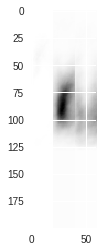

Batch 0. Loss 0.077544.
min -0.253457 max 0.999996


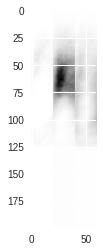

Batch 10. Loss 0.084426.
min -0.182965 max 0.999999


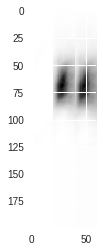

Batch 20. Loss 0.073734.
min -0.198438 max 0.999999


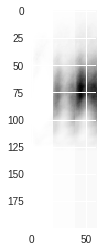

Batch 30. Loss 0.077664.
min -0.193410 max 0.999999


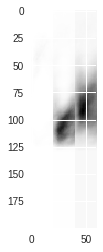

Batch 40. Loss 0.080584.
min -0.214996 max 0.999998


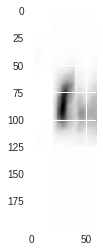

Batch 50. Loss 0.080961.
min -0.189974 max 0.999998


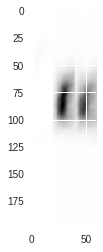

Batch 60. Loss 0.083646.
Test loss: 0.080938
Epoch 25
Batch 0. Loss 0.077548.
Batch 50. Loss 0.080443.
Batch 100. Loss 0.080499.
Batch 150. Loss 0.078117.
Batch 200. Loss 0.083715.
Batch 250. Loss 0.083524.
Batch 300. Loss 0.079731.
Batch 350. Loss 0.080223.
Batch 400. Loss 0.075227.
Batch 450. Loss 0.084000.
Batch 500. Loss 0.081426.
Batch 550. Loss 0.082923.
Train loss: 0.079534
Testing...
min -0.196288 max 0.999999


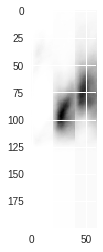

Batch 0. Loss 0.078206.
min -0.203662 max 1.000000


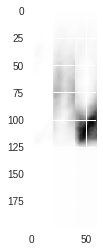

Batch 10. Loss 0.078186.
min -0.313094 max 0.999999


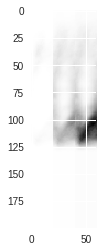

Batch 20. Loss 0.077523.
min -0.244510 max 0.999999


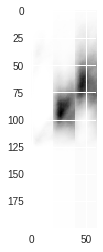

Batch 30. Loss 0.077721.
min -0.153975 max 0.999999


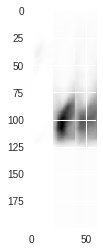

Batch 40. Loss 0.081858.
min -0.292850 max 0.999999


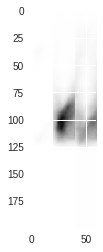

Batch 50. Loss 0.079165.
min -0.082760 max 0.999999


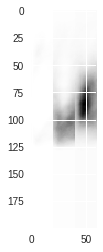

Batch 60. Loss 0.077745.
Test loss: 0.079905
Epoch 26
Batch 0. Loss 0.077354.
Batch 50. Loss 0.074200.
Batch 100. Loss 0.078125.
Batch 150. Loss 0.077837.
Batch 200. Loss 0.077280.
Batch 250. Loss 0.082066.
Batch 300. Loss 0.075530.
Batch 350. Loss 0.080786.
Batch 400. Loss 0.075584.
Batch 450. Loss 0.081091.
Batch 500. Loss 0.081127.
Batch 550. Loss 0.075622.
Train loss: 0.079243
Testing...
min -0.244928 max 0.999999


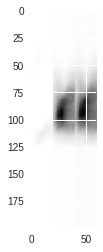

Batch 0. Loss 0.082460.
min -0.479291 max 0.999999


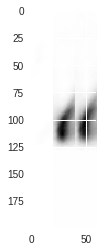

Batch 10. Loss 0.077736.
min -0.233159 max 0.999999


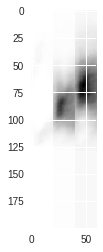

Batch 20. Loss 0.078381.
min -0.229060 max 0.999999


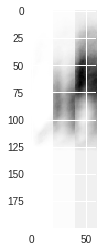

Batch 30. Loss 0.081924.
min -0.214421 max 0.999999


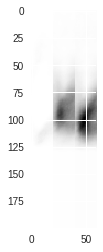

Batch 40. Loss 0.084451.
min -0.213903 max 0.999999


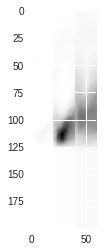

Batch 50. Loss 0.076898.
min -0.348115 max 0.999999


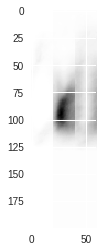

Batch 60. Loss 0.081797.
Test loss: 0.081279
Epoch 27
Batch 0. Loss 0.079500.
Batch 50. Loss 0.079256.
Batch 100. Loss 0.078411.
Batch 150. Loss 0.086253.
Batch 200. Loss 0.081661.
Batch 250. Loss 0.080287.
Batch 300. Loss 0.072787.
Batch 350. Loss 0.078144.
Batch 400. Loss 0.079603.
Batch 450. Loss 0.082112.
Batch 500. Loss 0.081369.
Batch 550. Loss 0.073467.
Train loss: 0.079132
Testing...
min -0.264704 max 0.999999


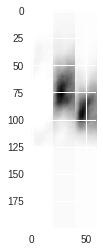

Batch 0. Loss 0.083239.
min -0.247952 max 0.999999


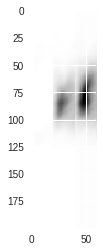

Batch 10. Loss 0.075121.
min -0.234043 max 0.999997


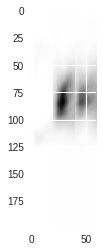

Batch 20. Loss 0.080924.
min -0.173719 max 0.999999


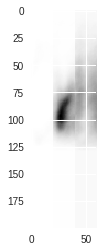

Batch 30. Loss 0.083493.
min -0.248708 max 0.999998


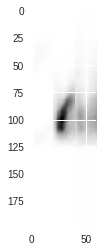

Batch 40. Loss 0.081267.
min -0.285546 max 0.999998


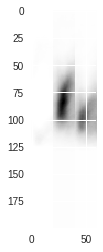

Batch 50. Loss 0.077719.
min -0.182068 max 1.000000


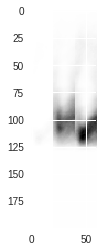

Batch 60. Loss 0.080640.
Test loss: 0.080177
Epoch 28
Batch 0. Loss 0.081407.
Batch 50. Loss 0.084547.
Batch 100. Loss 0.081047.
Batch 150. Loss 0.076817.
Batch 200. Loss 0.079597.
Batch 250. Loss 0.077365.
Batch 300. Loss 0.078952.
Batch 350. Loss 0.079114.
Batch 400. Loss 0.077492.
Batch 450. Loss 0.079156.
Batch 500. Loss 0.075294.
Batch 550. Loss 0.084957.
Train loss: 0.078930
Testing...
min -0.170355 max 1.000000


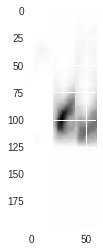

Batch 0. Loss 0.075166.
min -0.254859 max 1.000000


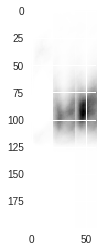

Batch 10. Loss 0.080847.
min -0.174692 max 1.000000


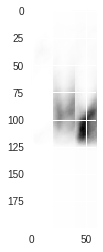

Batch 20. Loss 0.076625.
min -0.157081 max 1.000000


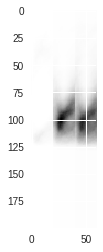

Batch 30. Loss 0.079591.
min -0.212268 max 1.000000


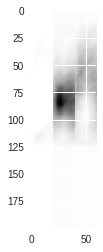

Batch 40. Loss 0.075088.
min -0.236992 max 1.000000


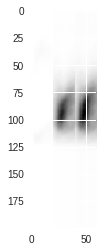

Batch 50. Loss 0.079440.
min -0.245892 max 0.999999


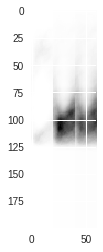

Batch 60. Loss 0.081899.
Test loss: 0.079784
Epoch 29
Batch 0. Loss 0.080042.
Batch 50. Loss 0.078216.
Batch 100. Loss 0.081336.
Batch 150. Loss 0.076877.
Batch 200. Loss 0.078465.
Batch 250. Loss 0.082399.
Batch 300. Loss 0.075387.
Batch 350. Loss 0.078802.
Batch 400. Loss 0.075283.
Batch 450. Loss 0.075752.
Batch 500. Loss 0.080351.
Batch 550. Loss 0.078457.
Train loss: 0.078961
Testing...
min -0.360664 max 0.999999


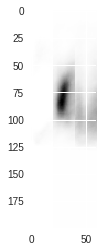

Batch 0. Loss 0.080400.
min -0.215483 max 0.999999


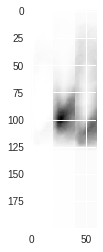

Batch 10. Loss 0.081568.
min -0.295405 max 1.000000


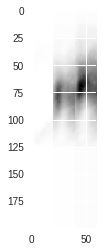

Batch 20. Loss 0.077037.
min -0.264533 max 0.999999


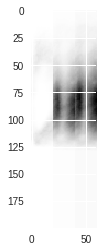

Batch 30. Loss 0.083243.
min -0.201013 max 1.000000


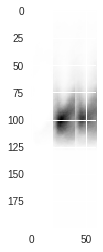

Batch 40. Loss 0.079486.
min -0.251887 max 1.000000


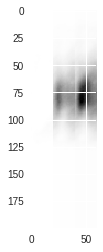

Batch 50. Loss 0.078333.
min -0.261696 max 1.000000


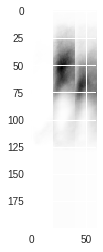

Batch 60. Loss 0.076870.
Test loss: 0.079574
Epoch 30
Batch 0. Loss 0.079474.
Batch 50. Loss 0.082820.
Batch 100. Loss 0.076412.
Batch 150. Loss 0.080438.
Batch 200. Loss 0.077315.
Batch 250. Loss 0.079014.
Batch 300. Loss 0.077733.
Batch 350. Loss 0.078179.
Batch 400. Loss 0.079143.
Batch 450. Loss 0.078340.
Batch 500. Loss 0.081645.
Batch 550. Loss 0.077177.
Train loss: 0.078934
Testing...
min -0.279784 max 0.999999


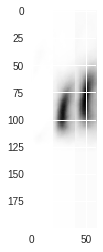

Batch 0. Loss 0.080401.
min -0.254499 max 0.999999


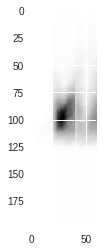

Batch 10. Loss 0.076516.
min -0.261471 max 0.999999


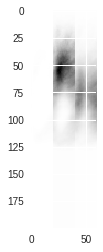

Batch 20. Loss 0.083297.
min -0.134636 max 0.999998


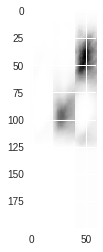

Batch 30. Loss 0.086010.
min -0.299425 max 0.999999


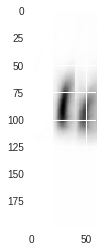

Batch 40. Loss 0.079530.
min -0.280188 max 1.000000


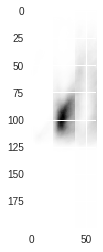

Batch 50. Loss 0.080293.
min -0.268213 max 0.999999


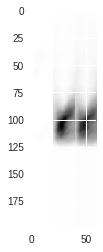

Batch 60. Loss 0.079863.
Test loss: 0.079680
Epoch 31
Batch 0. Loss 0.083584.
Batch 50. Loss 0.077348.
Batch 100. Loss 0.080157.
Batch 150. Loss 0.075507.
Batch 200. Loss 0.075995.
Batch 250. Loss 0.070163.
Batch 300. Loss 0.079775.
Batch 350. Loss 0.081307.
Batch 400. Loss 0.077874.
Batch 450. Loss 0.082247.
Batch 500. Loss 0.078553.
Batch 550. Loss 0.079792.
Train loss: 0.078549
Testing...
min -0.270785 max 0.999999


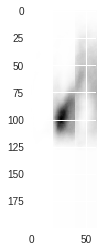

Batch 0. Loss 0.085024.
min -0.225058 max 0.999999


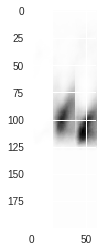

Batch 10. Loss 0.075916.
min -0.312678 max 0.999999


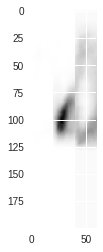

Batch 20. Loss 0.079827.
min -0.277042 max 0.999998


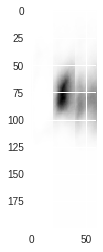

Batch 30. Loss 0.084075.
min -0.182649 max 0.999999


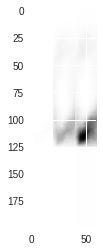

Batch 40. Loss 0.079193.
min -0.197243 max 0.999999


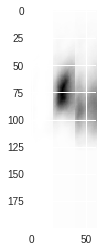

Batch 50. Loss 0.079657.
min -0.226571 max 0.999999


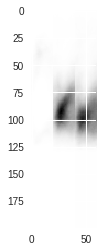

Batch 60. Loss 0.082414.
Test loss: 0.079763
Epoch 32
Batch 0. Loss 0.079513.
Batch 50. Loss 0.075015.
Batch 100. Loss 0.078878.
Batch 150. Loss 0.080674.
Batch 200. Loss 0.073191.
Batch 250. Loss 0.078059.
Batch 300. Loss 0.079856.
Batch 350. Loss 0.078926.
Batch 400. Loss 0.076584.
Batch 450. Loss 0.079833.
Batch 500. Loss 0.076660.
Batch 550. Loss 0.083853.
Train loss: 0.078673
Testing...
min -0.246580 max 0.999999


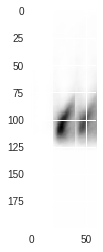

Batch 0. Loss 0.075286.
min -0.313350 max 0.999999


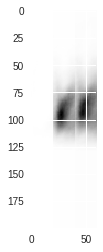

Batch 10. Loss 0.076313.
min -0.284551 max 0.999999


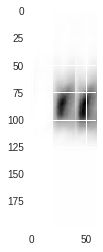

Batch 20. Loss 0.077558.
min -0.174355 max 0.999999


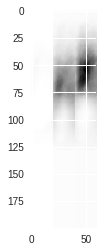

Batch 30. Loss 0.080519.
min -0.289477 max 0.999999


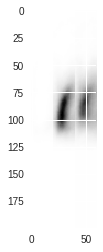

Batch 40. Loss 0.087967.
min -0.237144 max 0.999997


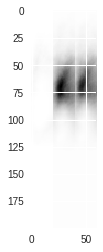

Batch 50. Loss 0.079611.
min -0.254859 max 0.999999


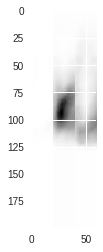

Batch 60. Loss 0.080192.
Test loss: 0.079637
Epoch 33
Batch 0. Loss 0.079325.
Batch 50. Loss 0.074043.
Batch 100. Loss 0.076861.
Batch 150. Loss 0.077609.
Batch 200. Loss 0.077462.
Batch 250. Loss 0.080993.
Batch 300. Loss 0.081018.
Batch 350. Loss 0.072349.
Batch 400. Loss 0.084717.
Batch 450. Loss 0.081285.
Batch 500. Loss 0.079662.
Batch 550. Loss 0.079165.
Train loss: 0.078985
Testing...
min -0.212084 max 0.999999


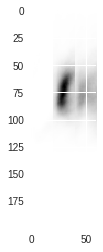

Batch 0. Loss 0.080326.
min -0.135396 max 0.999999


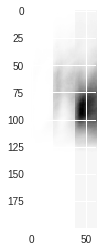

Batch 10. Loss 0.078463.
min -0.233210 max 0.999999


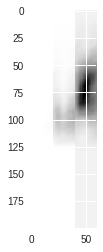

Batch 20. Loss 0.077543.
min -0.222623 max 0.999999


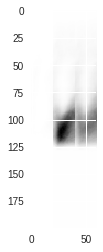

Batch 30. Loss 0.080064.
min -0.212807 max 0.999999


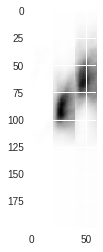

Batch 40. Loss 0.078615.
min -0.169005 max 0.999993


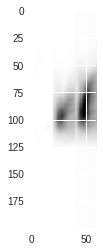

Batch 50. Loss 0.079530.
min -0.153879 max 0.999998


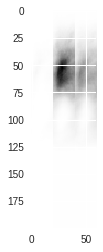

Batch 60. Loss 0.082814.
Test loss: 0.079493
Epoch 34
Batch 0. Loss 0.075451.
Batch 50. Loss 0.078779.
Batch 100. Loss 0.081105.
Batch 150. Loss 0.079910.
Batch 200. Loss 0.076472.
Batch 250. Loss 0.075168.
Batch 300. Loss 0.076382.
Batch 350. Loss 0.075970.
Batch 400. Loss 0.078171.
Batch 450. Loss 0.077986.
Batch 500. Loss 0.076904.
Batch 550. Loss 0.081734.
Train loss: 0.078442
Testing...
min -0.089578 max 0.999988


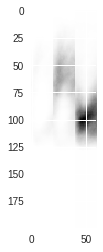

Batch 0. Loss 0.082119.
min -0.271133 max 0.999999


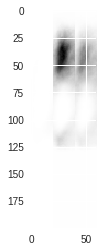

Batch 10. Loss 0.082749.
min -0.226214 max 0.999990


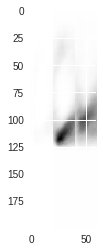

Batch 20. Loss 0.076814.
min -0.235637 max 0.999999


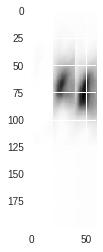

Batch 30. Loss 0.082553.
min -0.293351 max 0.999999


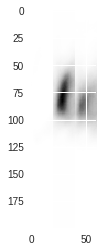

Batch 40. Loss 0.081118.
min -0.181030 max 0.999999


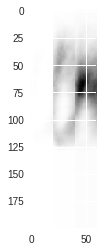

Batch 50. Loss 0.073304.
min -0.237185 max 0.999998


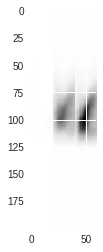

Batch 60. Loss 0.079210.
Test loss: 0.079374
Epoch 35
Batch 0. Loss 0.081861.
Batch 50. Loss 0.076641.
Batch 100. Loss 0.076748.
Batch 150. Loss 0.072522.
Batch 200. Loss 0.070187.
Batch 250. Loss 0.079054.
Batch 300. Loss 0.081590.
Batch 350. Loss 0.079792.


KeyboardInterrupt: ignored

In [0]:
for i in range(0, 100):
  train(i)
  with torch.no_grad():
    test(i)

In [0]:
test(1)

In [0]:
test(0)